In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('C:/Users/KimDongyoung/Desktop/Github/my_git/mygit/DEEPLEARNING/밑바닥부터시작하는딥러닝2')  # 부모 디렉터리의 파일을 가져올 수 있도록 설정

In [2]:
class sigmoid:
  def __init__(self): # 인스턴스 메서드 
    self.params = [] # sigmoid 계층에는 학습하는 매개변수가 따로 없으므로 빈 리스트로 초기화한다.
  
  # forward 메서드는 입력 데이터를 받아 순전파를 수행해 활성화 함수의 출력을 반환한다.
  def forward(self, x):
    return 1 / (1 + np.exp(-x)) 
  

In [3]:
class Affine:
  def __init__(self, W, b): # 인스턴스 메서드에서 가중치와 편향을 매개변수로 받아 인스턴스 변수인 params에 저장한다.
    self.params = [W, b]
  
  # forward 메서드는 입력 데이터를 받아 순전파를 수행해 가중치와 편향을 적용한 다음 결과를 반환한다.
  def forward(self, x):
    W, b = self.params
    out = np.dot(x, W) + b
    return out

### 신경망 '추론' 계층 구현  

In [4]:
# Affine - Sigmoid - Affine 계층으로 이어지는 추론 계층 구현
class TwoLayerNet:
  def __init__(self, input_size, hidden_size, output_size):
    I, H, O = input_size, hidden_size, output_size # 인수로 받은 input_size, hidden_size, output_size를 인스턴스 변수로 저장한다

    # 가중치와 편향 초기화
    # 정규분포를 따르는 난수로 가중치와 편향을 랜덤하게 초기화한다.
    W1 = np.random.randn(I, H)
    b1 = np.random.randn(H) # Hidden Layer의 뉴런 수만큼 편향을 생성한다.
    W2 = np.random.randn(H, O)
    b2 = np.random.randn(O) # Output Layer의 뉴런 수만큼 편향을 생성한다.

    # 계층 생성 Affine - Sigmoid - Affine
    self.layers = [
      Affine(W1, b1),
      sigmoid(),
      Affine(W2, b2)
    ]

    # 모든 가중치를 리스트에 모은다.
    self.params = []
    for layer in self.layers:
      self.params += layer.params

  # forward 메서드는 인수 x를 받아 신경망의 순전파를 수행해 결과를 반환한다.
  def forward(self, x):
    for layer in self.layers: # layers 리스트에 저장된 계층을 차례로 forward 메서드를 호출한다.
      x = layer.forward(x) # Affine.forward, sigmoid.forward, Affine.forward 순으로 호출된다.
    return x # Affine, sigmoid, Affine 순전파를 거친 결과를 반환한다.

In [5]:
x = np.random.randn(10, 2) # 입력 데이터 10개, 2차원
model = TwoLayerNet(2, 4, 3) # input_size=2, hidden_size=4, output_size=3
s = model.forward(x) # 순전파

In [6]:
print(s) # 출력 결과

[[-0.77846974  0.88054714  1.36992871]
 [-0.43649837  0.9761427   1.4059397 ]
 [-0.45360505  0.9963185   1.41324075]
 [-0.96486103  0.76424949  1.32990811]
 [-0.5574299   0.80416747  1.29163045]
 [-0.43276453  1.00439282  1.42688991]
 [-0.4542669   1.01634626  1.4265697 ]
 [-0.44249328  1.05129771  1.45358253]
 [-0.64623313  1.05449226  1.4611763 ]
 [-0.57505688  0.84092113  1.3166675 ]]


### 신경망 추론과 학습을 포함한 계층 구현  

In [7]:
# 순전파와 역전파를 모두 구현한 sigmoid 계층
class sigmoid:
  def __init__(self):
      self.params, self.grads = [], [] # params와 grads를 빈 리스트로 초기화한다. params는 가중치 매개변수를, grads는 기울기를 저장한다.
      self.out = None # 순전파의 출력을 보관한다.
  
  # 순전파 메서드는 입력 데이터를 받아 활성화 함수를 적용한 다음 결과를 반환한다.
  def forward(self, x):
      out = 1 / (1 + np.exp(-x))
      self.out = out
      return out # 순전파의 출력을 out에 저장하고 반환한다.
    
  # 역전파를 계산할 때 out 변수를 사용한다.
  def backward(self, dout):
      dx = dout * (1.0 - self.out) * self.out # y = 1 / (1 + exp(-x))의 미분은 y(1-y)이다.
      return dx
  

In [8]:
# 순전파와 역전파를 모두 구현한 Affine 계층
class Affine:
  def __init__(self, W, b):
      self.params = [W, b] # 가중치와 편향을 params에 저장한다.
      self.grads = [np.zeros_like(W), np.zeros_like(b)] # 가중치와 편향의 기울기를 grads에 저장한다.
      self.x = None # 순전파의 입력을 보관한다.
  
  # 순전파 메서드는 입력 데이터를 받아 가중치와 편향을 적용한 다음 결과를 반환한다.
  def forward(self, x):
      W, b = self.params
      out = np.dot(x, W) + b
      self.x = x
      return out # 순전파의 입력을 x에 저장하고 결과를 반환한다.
  
  # 역전파 메서드는 상류에서 전해지는 기울기 dout을 받아 가중치와 편향의 기울기를 계산하고 하류로 전달한다.
  def backward(self, dout):
      W, b = self.params
      dx = np.dot(dout, W.T) # dx = dout * W^T, dL/dy * W^T, 입력 x에 대한 상류 값의 미분으로 이전 층으로 전파해야 할 값이다
      dW = np.dot(self.x.T, dout) # dW = x^T * dout, X^T * dL/dy, 가중치 W에 대한 손실 함수의 기울기이다.
      db = np.sum(dout, axis=0) # # db = dL/dy의 각 원소의 총합이다, axis = 0은 행 방향으로 더한다
      self.grads[0][...] = dW # 가중치의 기울기를 grads에 저장한다.
      self.grads[1][...] = db # 편향의 기울기를 grads에 저장한다.
      
      return dx # 역전파의 결과 x에 대한 손실함수의 기울기를 반환한다.

In [9]:
def softmax(x):
  # 입력 데이터가 2차원 배열일 때는 배치용 softmax 함수를 적용한다.
  if x.ndim == 2:
    x = x - x.max(axis=1, keepdims=True)
    x = np.exp(x)
    x /= x.sum(axis=1, keepdims=True)
    
  # 입력 데이터가 1차원 배열일 때는 기본 softmax 함수를 적용한다.
  elif x.ndim == 1:
    x = x - np.max(x)
    x = np.exp(x) / np.sum(np.exp(x))
  return x

def cross_entropy_error(y, t): # y는 신경망의 출력(예측 값), t는 정답 레이블
  # 데이터가 하나인 경우, 데이터의 형상을 바꿔준다.
  if y.ndim == 1:
    t = t.reshape(1, t.size)
    y = y.reshape(1, y.size)
    
  # 정답 레이블 크기와 예측 값 크기가 같으면 정답 레이블의 인덱스로 반환한다.
  if t.size == y.size:
    t = t.argmax(axis=1) # 원 핫 인코딩된 정답 레이블을 인덱스로 변환한다. 즉 1(정답)의 위치를 반환한다.
          
  batch_size = y.shape[0] # 배치 크기를 구한다.
  return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size # 평균 교차 엔트로피 오차를 반환한다.

In [10]:
# 순전파와 역전파를 모두 구현한 Softmax with Loss 계층
class SoftmaxWithLoss:
    def __init__(self):
      self.params, self.grads = [], []
      self.y = None # softmax의 출력
      self.t = None # 정답 레이블
      
  # 순전파 메서드는 입력 데이터와 정답 레이블을 받아 소프트맥스 함수와 교차 엔트로피 오차를 적용한 다음 결과를 반환한다.
  # softmax, cross_entropy_error 함수를 통해 소프트맥스 함수와 교차 엔트로피 오차를 구한다.
    def forward(self, x, t):
        self.t = t
      # 예측 값을 softmax 함수를 통해 구한다.
        self.y = softmax(x)
      
      # 정답 레이블이 원-핫 벡터일 경우 정답 레이블의 인덱스로 변환한다.
        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)
          
        loss = cross_entropy_error(self.y, self.t) # cross_entropy_error 함수를 통해 정답과 예측 값의 교차 엔트로피 오차를 구한다.
        return loss # 오차 값을 반환한다.
  
    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1
        dx *= dout
        dx = dx / batch_size

        return dx
    
  

### 신경망으로 문제풀기  

In [11]:
# spiral 데이터셋을 생성하는 코드
def load_data(seed=1984):
    np.random.seed(seed)
    N = 100  # 클래스당 샘플 수
    DIM = 2  # 데이터 요소 수
    CLS_NUM = 3  # 클래스 수

    x = np.zeros((N*CLS_NUM, DIM))
    t = np.zeros((N*CLS_NUM, CLS_NUM), dtype=int)  # 여기서 np.int를 int로 변경

    for j in range(CLS_NUM):
        for i in range(N):
            rate = i / N
            radius = 1.0 * rate
            theta = j * 4.0 + 4.0 * rate + np.random.randn() * 0.2
            ix = N * j + i
            x[ix] = np.array([radius * np.sin(theta), radius * np.cos(theta)]).flatten()
            t[ix, j] = 1

    return x, t

In [12]:
x,t = load_data()
print('x:', x.shape) # x: (300, 2) x는 2차원 데이터이다. 300개의 데이터가 있고 각 데이터는 2차원이다.
print('t:', t.shape) # t: (300, 3) t는 원-핫 벡터로 3차원 데이터이다. 정답에 해당하는 요소만 1이고 나머지는 0이다.

x: (300, 2)
t: (300, 3)


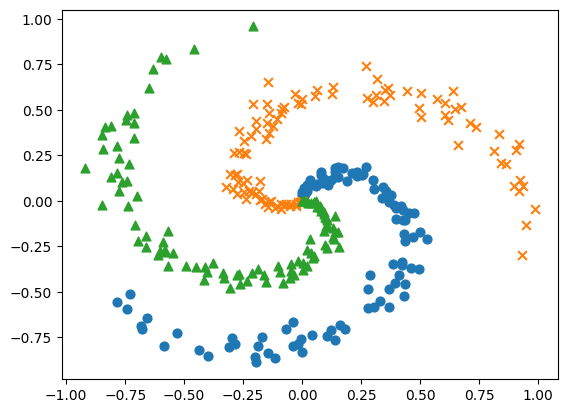

In [13]:
# 시각화 코드
N = 100
CLS_NUM = 3
markers = ['o', 'x', '^']
for i in range(CLS_NUM):
    plt.scatter(x[i*N:(i+1)*N, 0], x[i*N:(i+1)*N, 1], s=40, marker=markers[i])
plt.show()



In [14]:
# 신경망 학습 구현, Affine - Sigmoid - Affine - Softmax with loss 계층을 연결한 신경망을 구현한다.

class TwoLayerNet:
  # 초기화 메서드 __init__에서 input_size, hidden_size, output_size를 인수로 받는다.
  def __init__(self, input_size, hidden_size, output_size):
    I, H, O = input_size, hidden_size, output_size # input_size는 입력층의 뉴런 수, hidden_size는 은닉층의 뉴런 수, output_size는 출력층의 뉴런 수이다.
                                                  
    # 가중치와 편향 초기화
    W1 = 0.01 * np.random.randn(I, H)   # 표준편차가 0.01인 정규분포를 따르는 난수로 가중치를 초기화한다.
    b1 = np.zeros(H)                    # Hidden Layer의 뉴런 수만큼 편향을 생성한다. 전부 0으로 초기화한다.
    W2 = 0.01 * np.random.randn(H, O)   # 표준편차가 0.01인 정규분포를 따르는 난수로 가중치를 초기화한다.
    b2 = np.zeros(O)                    # Output Layer의 뉴런 수만큼 편향을 생성한다. 전부 0으로 초기화한다.

    # 계층 생성
    self.layers = [
      Affine(W1, b1),
      sigmoid(),
      Affine(W2, b2)
    ]
    self.loss_layer = SoftmaxWithLoss()

    # 모든 가중치와 기울기를 리스트에 모은다.
    self.params, self.grads = [], []
    for layer in self.layers: 
      self.params += layer.params # layers 리스트에 저장된 계층의 가중치 매개변수를 params에 추가한다.
      self.grads += layer.grads  # layers 리스트에 저장된 계층의 기울기를 grads에 추가한다.
  
  def predict(self,x):
    for layer in self.layers: 
      x = layer.forward(x) # layers 리스트에 저장된 계층을 차례로 forward 메서드를 호출한다.
      
    return x # Affine, sigmoid, Affine 순전파를 거친 결과를 반환한다.
  
  def forward(self, x, t):
    score = self.predict(x)
    loss = self.loss_layer.forward(score, t) # SoftmaxWithLoss 계층의 forward 메서드를 호출한다.
    
    return loss # 손실을 반환한다.
  
  def backward(self, dout=1):
    dout = self.loss_layer.backward(dout) # SoftmaxWithLoss 계층의 backward 메서드를 호출한다.
    for layer in reversed(self.layers): 
      dout = layer.backward(dout) # layers 리스트에 저장된 계층을 역순으로 backward 메서드를 호출한다. Affine, sigmoid, Affine 순서로 역전파를 거친다.
      
      return dout # 역전파의 결과를 반환한다.

In [15]:
# optimizer 계층 구현

# Optimizer로 SGD 확률적 경사 하강법을 구현한다.
class SGD:
  def __init__(self, lr=0.01):
    self.lr = lr # 학습률을 초기화한다.
  
  def update(self, params, grads):
    for i in range(len(params)): # params와 grads의 길이만큼 반복한다.
      params[i] -= self.lr * grads[i] # params와 grads의 원소를 갱신한다.

| 에폭 1 |  반복 10 / 10 | 손실 1.13
| 에폭 2 |  반복 10 / 10 | 손실 1.13
| 에폭 3 |  반복 10 / 10 | 손실 1.12
| 에폭 4 |  반복 10 / 10 | 손실 1.12
| 에폭 5 |  반복 10 / 10 | 손실 1.11
| 에폭 6 |  반복 10 / 10 | 손실 1.14
| 에폭 7 |  반복 10 / 10 | 손실 1.17
| 에폭 8 |  반복 10 / 10 | 손실 1.11
| 에폭 9 |  반복 10 / 10 | 손실 1.13
| 에폭 10 |  반복 10 / 10 | 손실 1.14
| 에폭 11 |  반복 10 / 10 | 손실 1.13
| 에폭 12 |  반복 10 / 10 | 손실 1.14
| 에폭 13 |  반복 10 / 10 | 손실 1.12
| 에폭 14 |  반복 10 / 10 | 손실 1.14
| 에폭 15 |  반복 10 / 10 | 손실 1.14
| 에폭 16 |  반복 10 / 10 | 손실 1.18
| 에폭 17 |  반복 10 / 10 | 손실 1.14
| 에폭 18 |  반복 10 / 10 | 손실 1.14
| 에폭 19 |  반복 10 / 10 | 손실 1.19
| 에폭 20 |  반복 10 / 10 | 손실 1.16
| 에폭 21 |  반복 10 / 10 | 손실 1.15
| 에폭 22 |  반복 10 / 10 | 손실 1.13
| 에폭 23 |  반복 10 / 10 | 손실 1.13
| 에폭 24 |  반복 10 / 10 | 손실 1.13
| 에폭 25 |  반복 10 / 10 | 손실 1.20
| 에폭 26 |  반복 10 / 10 | 손실 1.12
| 에폭 27 |  반복 10 / 10 | 손실 1.12
| 에폭 28 |  반복 10 / 10 | 손실 1.12
| 에폭 29 |  반복 10 / 10 | 손실 1.16
| 에폭 30 |  반복 10 / 10 | 손실 1.15
| 에폭 31 |  반복 10 / 10 | 손실 1.25
| 에폭 32 |  반복 10 

c:\Users\KimDongyoung\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\KimDongyoung\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\KimDongyoung\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\KimDongyoung\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


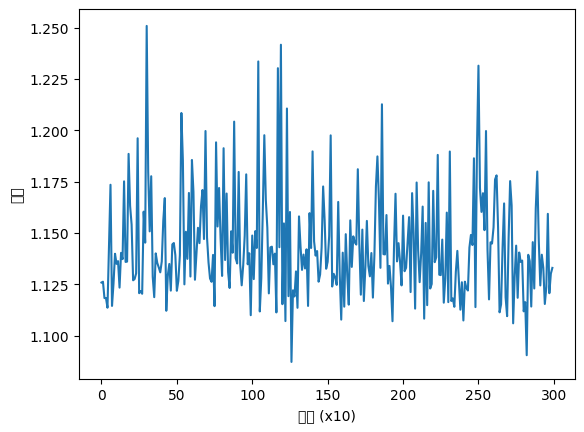

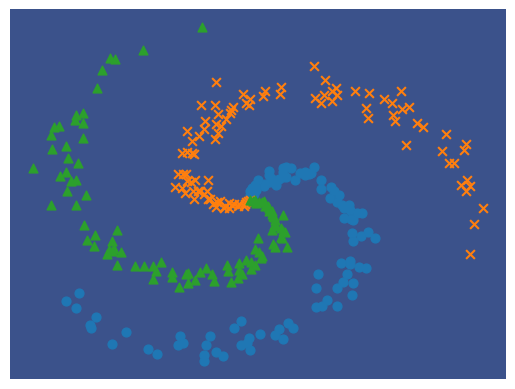

In [16]:
max_epoch = 300
batch_size = 30
hidden_size = 10
learning_rate = 1.0

x, t = load_data() # x는 2차원 데이터이다. 300개의 데이터가 있고 각 데이터는 2차원이다. t는 3차원 데이터이다. 정답에 해당하는 요소만 1이고 나머지는 0이다.
model = TwoLayerNet(input_size=2, hidden_size=hidden_size, output_size=3) # input_size=2, hidden_size=hidden_size, output_size=3
optimizer = SGD(lr=learning_rate) # 학습률이 0.01인 SGD를 사용한다.

# 학습에 사용하는 변수
data_size = len(x)
max_iters = data_size // batch_size # 300 // 30 = 10
total_loss = 0
loss_count = 0
loss_list = []

for epoch in range(max_epoch):
  # 데이터 뒤섞기
  idx = np.random.permutation(data_size) # 데이터의 인덱스를 뒤섞는다.
  x = x[idx]
  t = t[idx]

  for iters in range(max_iters):
    batch_x = x[iters*batch_size:(iters+1)*batch_size] # 0:30, 30:60, 60:90, ... 270:300
    batch_t = t[iters*batch_size:(iters+1)*batch_size] # 0:30, 30:60, 60:90, ... 270:300

    # 기울기를 구해 매개변수 갱신
    loss = model.forward(batch_x, batch_t) # 손실을 구한다.
    model.backward() # 역전파를 통해 기울기를 구한다. 기울기는 models.grads에 저장된다.
    optimizer.update(model.params, model.grads) # SGD를 사용해 가중치를 갱신한다. 갱신된 가중치는 model.params에 저장된다.

    total_loss += loss
    loss_count += 1

    # 정기적으로 학습 경과 출력
    if (iters+1) % 10 == 0:
      avg_loss = total_loss / loss_count
      print('| 에폭 %d |  반복 %d / %d | 손실 %.2f' % (epoch + 1, iters + 1, max_iters, avg_loss))
      loss_list.append(avg_loss)
      total_loss, loss_count = 0, 0
      
# 학습 결과 플롯
plt.plot(np.arange(len(loss_list)), loss_list, label='train')
plt.xlabel('반복 (x10)')
plt.ylabel('손실')
plt.show()

# 경계 영역 플롯
h = 0.001
x_min, x_max = x[:, 0].min() - .1, x[:, 0].max() + .1
y_min, y_max = x[:, 1].min() - .1, x[:, 1].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
X = np.c_[xx.ravel(), yy.ravel()]
score = model.predict(X)
predict_cls = np.argmax(score, axis=1)
Z = predict_cls.reshape(xx.shape)
plt.contourf(xx, yy, Z)
plt.axis('off')

# 데이터점 플롯
x, t = load_data()
N = 100
CLS_NUM = 3
markers = ['o', 'x', '^']
for i in range(CLS_NUM):
    plt.scatter(x[i*N:(i+1)*N, 0], x[i*N:(i+1)*N, 1], s=40, marker=markers[i])
plt.show()

In [17]:
from common.layers import Sigmoid, Affine, SoftmaxWithLoss

In [18]:
class TwoLayerNet:
  def __init__(self, input_size, hidden_size, output_size):
    I, H, O = input_size, hidden_size, output_size

    # 가중치와 편향 초기화
    W1 = 0.01 * np.random.randn(I, H)
    b1 = np.zeros(H)
    W2 = 0.01 * np.random.randn(H, O)
    b2 = np.zeros(O)

    # 계층 생성
    self.layers = [
      Affine(W1, b1),
      Sigmoid(),
      Affine(W2, b2)
    ]
    self.loss_layer = SoftmaxWithLoss()

    # 모든 가중치와 기울기를 리스트에 모은다.
    self.params, self.grads = [], []
    for layer in self.layers:
      self.params += layer.params
      self.grads += layer.grads